In [ ]:
import tensorflow as tf
#Enable GPU 
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored

1. Create custom CNN and train/validate/test it on Stanford 40

In [ ]:
!wget http://vision.stanford.edu/Datasets/Stanford40_JPEGImages.zip
!wget http://vision.stanford.edu/Datasets/Stanford40_ImageSplits.zip
!unzip Stanford40_JPEGImages.zip -d Stanford40/
!unzip Stanford40_ImageSplits.zip -d Stanford40/

with open('Stanford40/ImageSplits/train.txt', 'r') as f:
    train_files = list(map(str.strip, f.readlines()))
    train_labels = ['_'.join(name.split('_')[:-1]) for name in train_files]
    print(f'Train files ({len(train_files)}):\n\t{train_files}')
    print(f'Train labels ({len(train_labels)}):\n\t{train_labels}\n')

import os
from os import path
if not path.exists("Stanford40/JPEGImages/train/"):
  os.mkdir("Stanford40/JPEGImages/train/")
for i in range(len(train_files)):
  label = train_labels[i]
  file = train_files[i]
  if not path.exists("Stanford40/JPEGImages/train/" + label):
    os.mkdir("Stanford40/JPEGImages/train/" + label)
  if path.exists("Stanford40/JPEGImages/" + file):
    os.rename("Stanford40/JPEGImages/" + file, "Stanford40/JPEGImages/train/" + label + "/" + file)
  if path.exists("Stanford40/JPEGImages/train/" + file):
    os.rename("Stanford40/JPEGImages/train/" + file, "Stanford40/JPEGImages/train/" + label + "/" + file)

with open('Stanford40/ImageSplits/test.txt', 'r') as f:
    test_files = list(map(str.strip, f.readlines()))
    test_labels = ['_'.join(name.split('_')[:-1]) for name in test_files]
    print(f'Test files ({len(test_files)}):\n\t{test_files}')
    print(f'Test labels ({len(test_labels)}):\n\t{test_labels}\n')
    
if not path.exists("Stanford40/JPEGImages/test/"):
  os.mkdir("Stanford40/JPEGImages/test/")
for i in range(len(test_files)):
  label = test_labels[i]
  file = test_files[i]
  if not path.exists("Stanford40/JPEGImages/test/" + label):
    os.mkdir("Stanford40/JPEGImages/test/" + label)
  if path.exists("Stanford40/JPEGImages/" + file):
    os.rename("Stanford40/JPEGImages/" + file, "Stanford40/JPEGImages/test/" + label + "/" + file)
  if path.exists("Stanford40/JPEGImages/test/" + file):
    os.rename("Stanford40/JPEGImages/test/" + file, "Stanford40/JPEGImages/test/" + label + "/" + file)

action_categories = sorted(list(set(['_'.join(name.split('_')[:-1]) for name in train_files])))
print(f'Action categories ({len(action_categories)}):\n{action_categories}')

!pip install tensorflow

Streaming output truncated to the last 5000 lines.
  inflating: Stanford40/JPEGImages/playing_guitar_004.jpg  
  inflating: Stanford40/JPEGImages/playing_guitar_005.jpg  
  inflating: Stanford40/JPEGImages/playing_guitar_006.jpg  
  inflating: Stanford40/JPEGImages/playing_guitar_007.jpg  
  inflating: Stanford40/JPEGImages/playing_guitar_008.jpg  
  inflating: Stanford40/JPEGImages/playing_guitar_009.jpg  
  inflating: Stanford40/JPEGImages/playing_guitar_010.jpg  
  inflating: Stanford40/JPEGImages/playing_guitar_011.jpg  
  inflating: Stanford40/JPEGImages/playing_guitar_012.jpg  
  inflating: Stanford40/JPEGImages/playing_guitar_013.jpg  
  inflating: Stanford40/JPEGImages/playing_guitar_014.jpg  
  inflating: Stanford40/JPEGImages/playing_guitar_015.jpg  
  inflating: Stanford40/JPEGImages/playing_guitar_016.jpg  
  inflating: Stanford40/JPEGImages/playing_guitar_017.jpg  
  inflating: Stanford40/JPEGImages/playing_guitar_018.jpg  
  inflating: Stanford40/JPEGImages/playing_guitar

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras 
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout, Dense, Activation
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping
import os
import pathlib
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# define variables
NUM_EPOCHS = 10 # just for a few to run quickly
BATCH_SIZE = 32
img_height = 128 # images must be rescaled to uniform size.
img_width = 128
color_channels = 3
val_split = 0.1

# create datasets
train_data_dir = pathlib.Path('Stanford40/JPEGImages/train/')
test_data_dir = pathlib.Path('Stanford40/JPEGImages/test/')

# create iterators from Image Data Generator
# rescale here allows us to normalize the data from [0, 255] to [0,1]
traindatagen = ImageDataGenerator(validation_split=val_split,
                                  rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

train_it = traindatagen.flow_from_directory(
  train_data_dir, subset="training", class_mode='sparse', seed=None,
  target_size=(img_width,img_height), batch_size=1, color_mode="rgb")
# batchX, batchy = train_it.next()
# print('Train Batch shape=%s, min=%.3f, max=%.3f, std:%.3f' % (batchX.shape, batchX.min(), batchX.max(), batchX.std()))

from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

val_it = traindatagen.flow_from_directory(
  train_data_dir, subset="validation",  class_mode='sparse',seed=None,
  target_size=(img_width,img_height), batch_size=1, color_mode="rgb")
# batchX, batchy = val_it.next()
# print('Validation Batch shape=%s, min=%.3f, max=%.3f, std:%.3f' % (batchX.shape, batchX.min(), batchX.max(), batchX.std()))

testdatagen = ImageDataGenerator( rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True )

test_it = testdatagen.flow_from_directory(test_data_dir, class_mode='sparse',
    target_size=(img_width,img_height), batch_size=1, color_mode="rgb")
# batchX, batchy = test_it.next()
# print('Test Batch shape=%s, min=%.3f, max=%.3f, std:%.3f' % (batchX.shape, batchX.min(), batchX.max(), batchX.std()))

# x,y = train_it.next()
# import matplotlib.pyplot as plt
# for i in range(0,1):
#     image = x[i]
#     plt.imshow(image)
#     plt.show()

inputs = keras.Input(shape=(img_width, img_height, 3))

x = Conv2D(filters=8, kernel_size=(3,3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(filters=16, kernel_size=(3,3), activation='relu')(x)
x = MaxPooling2D(pool_size=(3,3))(x)
x = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Flatten()(x)
x = Dense(48, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(40, activation='softmax')(x)

stanford40_model = keras.Model(inputs, outputs)
stanford40_model.summary()

# from keras.optimizers import SGD
# opt = SGD(lr=0.0001)

filepath = '/content/drive/MyDrive/best_stanford_model.hdf5'

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0), 
            tf.keras.callbacks.ModelCheckpoint(filepath=filepath, 
            monitor='val_loss', verbose=0, save_best_only=True, mode='min')]

stanford40_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Fit the model to train set, validate it using validation set.
history_model1 = stanford40_model.fit(train_it, validation_data=val_it, epochs=NUM_EPOCHS, callbacks = [callbacks])

FileNotFoundError: ignored

In [ ]:
# Evaluate model on test set.
from keras.models import load_model
best_model_stanford = load_model('/content/drive/MyDrive/best_stanford_model.hdf5')
score = best_model_stanford.evaluate(test_it)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')
print(best_model_stanford.predict(test_it))

5532/5532 [==============================] - 71s 13ms/step - loss: 3.6888 - accuracy: 0.0273
Test loss: 3.6887707710266113 / Test accuracy: 0.027295734733343124
[[0.02521363 0.02509898 0.02480893 ... 0.02517726 0.02519231 0.02494543]
 [0.02521363 0.02509898 0.02480893 ... 0.02517726 0.02519231 0.02494543]
 [0.02521363 0.02509898 0.02480893 ... 0.02517726 0.02519231 0.02494543]
 ...
 [0.02521363 0.02509898 0.02480893 ... 0.02517726 0.02519231 0.02494543]
 [0.02521363 0.02509898 0.02480893 ... 0.02517726 0.02519231 0.02494543]
 [0.02521363 0.02509898 0.02480893 ... 0.02517726 0.02519231 0.02494543]]


In [ ]:
best_model_stanford.save_weights('/content/drive/MyDrive/best_stanford_model_weights.hdf5')

In [ ]:
import matplotlib.pyplot as plt
def print_loss_graph (model): 
  plt.plot(model.history['loss'], label='train_loss')
  plt.plot(model.history['val_loss'], label = 'val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(loc='lower right')
  plt.title('Loss per Epoch')
  return plt.show()

In [ ]:
def print_accuracy_graph (model): 
  plt.plot(model.history['accuracy'], label='acc')
  plt.plot(model.history['val_accuracy'], label = 'val_acc')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.title('Accuracy per Epoch')
  return plt.show()

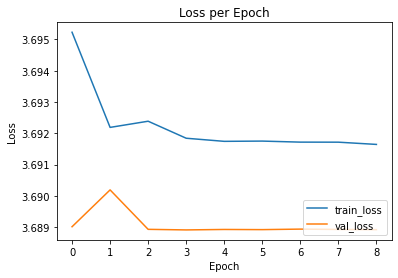

In [ ]:
print_loss_graph(history_model1)

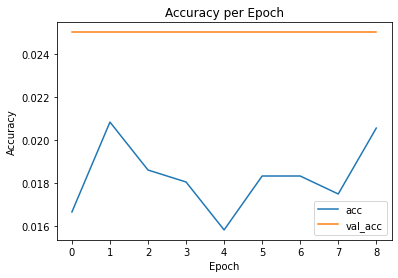

In [ ]:
print_accuracy_graph(history_model1)

2. Finetune Stanford40 model on TV-HI set


In [ ]:
!wget http://www.robots.ox.ac.uk/~alonso/data/tv_human_interactions_videos.tar.gz
!wget http://www.robots.ox.ac.uk/~alonso/data/readme.txt

!mkdir TV-HI
!tar -xvf  'tv_human_interactions_videos.tar.gz' -C TV-HI
!mv readme.txt 'TV-HI/readme.txt'

--2021-04-18 21:20:58--  http://www.robots.ox.ac.uk/~alonso/data/tv_human_interactions_videos.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~alonso/data/tv_human_interactions_videos.tar.gz [following]
--2021-04-18 21:20:58--  https://www.robots.ox.ac.uk/~alonso/data/tv_human_interactions_videos.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 163535078 (156M) [application/x-gzip]
Saving to: ‘tv_human_interactions_videos.tar.gz’

tv_human_interactio 100%[===================>] 155.96M  21.4MB/s    in 8.2s    

2021-04-18 21:21:07 (19.0 MB/s) - ‘tv_human_interactions_videos.tar.gz’ saved [163535078/163535078]

--2021-04-18 21:21:07--  http://www.robots.ox.ac.uk/~alonso/data/readme

In [ ]:

set_1_indices = [[2,14,15,16,18,19,20,21,24,25,26,27,28,32,40,41,42,43,44,45,46,47,48,49,50],
                 [1,6,7,8,9,10,11,12,13,23,24,25,27,28,29,30,31,32,33,34,35,44,45,47,48],
                 [2,3,4,11,12,15,16,17,18,20,21,27,29,30,31,32,33,34,35,36,42,44,46,49,50],
                 [1,7,8,9,10,11,12,13,14,16,17,18,22,23,24,26,29,31,35,36,38,39,40,41,42]]
set_2_indices = [[1,3,4,5,6,7,8,9,10,11,12,13,17,22,23,29,30,31,33,34,35,36,37,38,39],
                 [2,3,4,5,14,15,16,17,18,19,20,21,22,26,36,37,38,39,40,41,42,43,46,49,50],
                 [1,5,6,7,8,9,10,13,14,19,22,23,24,25,26,28,37,38,39,40,41,43,45,47,48],
                 [2,3,4,5,6,15,19,20,21,25,27,28,30,32,33,34,37,43,44,45,46,47,48,49,50]]
classes = ['handShake', 'highFive', 'hug', 'kiss']  # we ignore the negative class

# test set
set_1 = [f'{classes[c]}_{i:04d}.avi' for c in range(len(classes)) for i in set_1_indices[c]]
set_1_label = [f'{classes[c]}' for c in range(len(classes)) for i in set_1_indices[c]]
print(f'Set 1 to be used for test ({len(set_1)}):\n\t{set_1}')
print(f'Set 1 labels ({len(set_1_label)}):\n\t{set_1_label}\n')

# training set
set_2 = [f'{classes[c]}_{i:04d}.avi' for c in range(len(classes)) for i in set_2_indices[c]]
set_2_label = [f'{classes[c]}' for c in range(len(classes)) for i in set_2_indices[c]]
print(f'Set 2 to be used for train and validation ({len(set_2)}):\n\t{set_2}')
print(f'Set 2 labels ({len(set_2_label)}):\n\t{set_2_label}')

from moviepy.editor import *

import os
from os import path
if not path.exists("TV-HI/train/"):
  os.mkdir("TV-HI/train/")
if not path.exists("TV-HI/test/"):
  os.mkdir("TV-HI/test/")

for i in range(100):
  if not path.exists("TV-HI/train/" + set_1_label[i]):
    os.mkdir("TV-HI/train/" + set_1_label[i])
  test_clip = VideoFileClip(f'TV-HI/tv_human_interactions_videos/{set_1[i]}')
  middle_frame_t = test_clip.duration / 2
  test_clip.save_frame("TV-HI/train/" + set_1_label[i] + "/" + set_1[i] + ".png", middle_frame_t)
  
  if not path.exists("TV-HI/test/" + set_2_label[i]):
    os.mkdir("TV-HI/test/" + set_2_label[i])

  train_clip = VideoFileClip(f'TV-HI/tv_human_interactions_videos/{set_2[i]}')
  middle_frame_t = train_clip.duration / 2
  train_clip.save_frame("TV-HI/test/" + set_2_label[i] + "/"+ set_2[i] + ".png", middle_frame_t)

# create datasets 
tf_train_datagen = ImageDataGenerator(validation_split=val_split,
                                  rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

tf_train_it = tf_train_datagen.flow_from_directory(
  train_data_dir, subset="training", class_mode='sparse', seed=None, classes=['handShake', 'highFive', 'hug', 'kiss'],
  target_size=(img_width,img_height), batch_size=BATCH_SIZE, color_mode="rgb")

tf_val_it = tf_train_datagen.flow_from_directory(
  train_data_dir, subset="validation",  class_mode='sparse',seed=None, classes=['handShake', 'highFive', 'hug', 'kiss'],
  target_size=(img_width,img_height), batch_size=BATCH_SIZE, color_mode="rgb")

tf_test_datagen = ImageDataGenerator(validation_split=val_split,
                                  rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

tf_test_it = tf_test_datagen.flow_from_directory(
  test_data_dir,  class_mode='sparse',seed=None, classes=['handShake', 'highFive', 'hug', 'kiss'],
  target_size=(img_width,img_height), batch_size=BATCH_SIZE, color_mode="rgb")


best_stanford_model= load_model('/content/drive/MyDrive/best_stanford_model.hdf5')

temp = best_stanford_model
temp._layers.pop()

inputs = temp.input
outputs = Dense(4, activation='softmax')(temp._layers[-1].output)

tf_stanford40 = keras.Model(inputs, outputs)
tf_stanford40.summary()

filepath = '/content/drive/MyDrive/best_TV_hi_model.hdf5'

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0), 
            tf.keras.callbacks.ModelCheckpoint(filepath=filepath, 
            monitor='val_loss', verbose=0, save_best_only=True, mode='min')]


learning_rate = (keras.backend.eval(best_stanford_model.optimizer.lr)) / 10
tf_stanford40.compile(loss='sparse_categorical_crossentropy', 
                                    optimizer=tf.keras.optimizers.Adam(lr=learning_rate),metrics=['accuracy'])
tf_stanford40_history = tf_stanford40.fit(tf_train_it, validation_data=tf_val_it, epochs=50, callbacks = [callbacks])

Set 1 to be used for test (100):
	['handShake_0002.avi', 'handShake_0014.avi', 'handShake_0015.avi', 'handShake_0016.avi', 'handShake_0018.avi', 'handShake_0019.avi', 'handShake_0020.avi', 'handShake_0021.avi', 'handShake_0024.avi', 'handShake_0025.avi', 'handShake_0026.avi', 'handShake_0027.avi', 'handShake_0028.avi', 'handShake_0032.avi', 'handShake_0040.avi', 'handShake_0041.avi', 'handShake_0042.avi', 'handShake_0043.avi', 'handShake_0044.avi', 'handShake_0045.avi', 'handShake_0046.avi', 'handShake_0047.avi', 'handShake_0048.avi', 'handShake_0049.avi', 'handShake_0050.avi', 'highFive_0001.avi', 'highFive_0006.avi', 'highFive_0007.avi', 'highFive_0008.avi', 'highFive_0009.avi', 'highFive_0010.avi', 'highFive_0011.avi', 'highFive_0012.avi', 'highFive_0013.avi', 'highFive_0023.avi', 'highFive_0024.avi', 'highFive_0025.avi', 'highFive_0027.avi', 'highFive_0028.avi', 'highFive_0029.avi', 'highFive_0030.avi', 'highFive_0031.avi', 'highFive_0032.avi', 'highFive_0033.avi', 'highFive_0034.a

NameError: ignored

In [ ]:
# Evaluate model on test set.
from keras.models import load_model
best_model_tv_hi = load_model('/content/drive/MyDrive/best_TV_hi_model.hdf5')
score = best_model_tv_hi.evaluate(tf_test_it)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')
print(best_model_stanford.predict(test_it))

4/4 [==============================] - 2s 356ms/step - loss: 1.3863 - accuracy: 0.2500
Test loss: 1.3862943649291992 / Test accuracy: 0.25
[[0.02521363 0.02509898 0.02480893 ... 0.02517726 0.02519231 0.02494543]
 [0.02521363 0.02509898 0.02480893 ... 0.02517726 0.02519231 0.02494543]
 [0.02521363 0.02509898 0.02480893 ... 0.02517726 0.02519231 0.02494543]
 ...
 [0.02521363 0.02509898 0.02480893 ... 0.02517726 0.02519231 0.02494543]
 [0.02521363 0.02509898 0.02480893 ... 0.02517726 0.02519231 0.02494543]
 [0.02521363 0.02509898 0.02480893 ... 0.02517726 0.02519231 0.02494543]]


In [ ]:
best_model_tv_hi.save_weights('best_TV_hi_model_weights.hdf5')

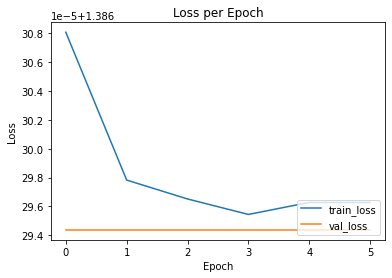

In [ ]:
print_loss_graph(tf_stanford40_history)

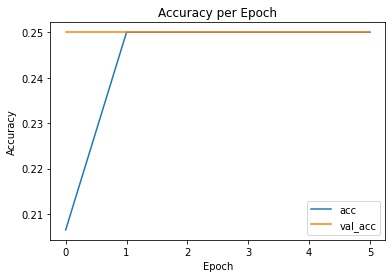

In [ ]:
print_accuracy_graph(tf_stanford40_history)

3. Load optical flow data TV-HI


In [ ]:
set_1_indices = [[2,14,15,16,18,19,20,21,24,25,26,27,28,32,40,41,42,43,44,45,46,47,48,49,50],
                 [1,6,7,8,9,10,11,12,13,23,24,25,27,28,29,30,31,32,33,34,35,44,45,47,48],
                 [2,3,4,11,12,15,16,17,18,20,21,27,29,30,31,32,33,34,35,36,42,44,46,49,50],
                 [1,7,8,9,10,11,12,13,14,16,17,18,22,23,24,26,29,31,35,36,38,39,40,41,42]]
set_2_indices = [[1,3,4,5,6,7,8,9,10,11,12,13,17,22,23,29,30,31,33,34,35,36,37,38,39],
                 [2,3,4,5,14,15,16,17,18,19,20,21,22,26,36,37,38,39,40,41,42,43,46,49,50],
                 [1,5,6,7,8,9,10,13,14,19,22,23,24,25,26,28,37,38,39,40,41,43,45,47,48],
                 [2,3,4,5,6,15,19,20,21,25,27,28,30,32,33,34,37,43,44,45,46,47,48,49,50]]
classes = ['handShake', 'highFive', 'hug', 'kiss']  # we ignore the negative class

# test set
set_1 = [f'{classes[c]}_{i:04d}.avi' for c in range(len(classes)) for i in set_1_indices[c]]
set_1_label = [f'{classes[c]}' for c in range(len(classes)) for i in set_1_indices[c]]
print(f'Set 1 to be used for test ({len(set_1)}):\n\t{set_1}')
print(f'Set 1 labels ({len(set_1_label)}):\n\t{set_1_label}\n')

# training set
set_2 = [f'{classes[c]}_{i:04d}.avi' for c in range(len(classes)) for i in set_2_indices[c]]
set_2_label = [f'{classes[c]}' for c in range(len(classes)) for i in set_2_indices[c]]
print(f'Set 2 to be used for train and validation ({len(set_2)}):\n\t{set_2}')
print(f'Set 2 labels ({len(set_2_label)}):\n\t{set_2_label}')

Set 1 to be used for test (100):
	['handShake_0002.avi', 'handShake_0014.avi', 'handShake_0015.avi', 'handShake_0016.avi', 'handShake_0018.avi', 'handShake_0019.avi', 'handShake_0020.avi', 'handShake_0021.avi', 'handShake_0024.avi', 'handShake_0025.avi', 'handShake_0026.avi', 'handShake_0027.avi', 'handShake_0028.avi', 'handShake_0032.avi', 'handShake_0040.avi', 'handShake_0041.avi', 'handShake_0042.avi', 'handShake_0043.avi', 'handShake_0044.avi', 'handShake_0045.avi', 'handShake_0046.avi', 'handShake_0047.avi', 'handShake_0048.avi', 'handShake_0049.avi', 'handShake_0050.avi', 'highFive_0001.avi', 'highFive_0006.avi', 'highFive_0007.avi', 'highFive_0008.avi', 'highFive_0009.avi', 'highFive_0010.avi', 'highFive_0011.avi', 'highFive_0012.avi', 'highFive_0013.avi', 'highFive_0023.avi', 'highFive_0024.avi', 'highFive_0025.avi', 'highFive_0027.avi', 'highFive_0028.avi', 'highFive_0029.avi', 'highFive_0030.avi', 'highFive_0031.avi', 'highFive_0032.avi', 'highFive_0033.avi', 'highFive_0034.a

In [ ]:
cd /content/TV-HI/tv_human_interactions_videos/

/content/TV-HI/tv_human_interactions_videos


In [ ]:
import cv2
import numpy as np
%matplotlib inline
from google.colab.patches import cv2_imshow
from skimage.transform import resize

In [ ]:
#DONT RUN
def get_opticalflow(video_name):
  optical_flow = []
  cap = cv2.VideoCapture(video_name)
  length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  label = set_2_label[i]

  ret, frame1 = cap.read()
  prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
  hsv = np.zeros_like(frame1)
  hsv[...,1] = 255

  while(1):
      ret, frame2 = cap.read()
      if not ret:
        break
      next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

      flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

      mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
      # Set image hue according to the optical flow direction
      hsv[...,0] = ang*180/np.pi/2
      # Set image value according to the optical flow magnitude (normalized)
      hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)

      rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
      resized = resize(rgb, (128, 128))

      optical_flow.append(resized)

      prvs = next

  cap.release()
  cv2.destroyAllWindows()

  return optical_flow

In [ ]:
#DONT RUN
total_optical_flow = []
for i in range(0, len(set_2)): 
  video = set_2[i]
  opticalflow_video = get_opticalflow(video)
  start_frame = int(np.floor(len(opticalflow_video)/2)-8)
  end_frame = int(np.floor(len(opticalflow_video)/2)+8)
  remaining_frames = np.array(opticalflow_video[start_frame:end_frame])
  total_optical_flow.append(remaining_frames)

In [ ]:
#DONT RUN
total_optical_flow_test = []
for i in range(0, len(set_1)): 
  video = set_1[i]
  opticalflow_video = get_opticalflow(video)
  start_frame = int(np.floor(len(opticalflow_video)/2)-8)
  end_frame = int(np.floor(len(opticalflow_video)/2)+8)
  remaining_frames = np.array(opticalflow_video[start_frame:end_frame])
  total_optical_flow_test.append(remaining_frames)

In [ ]:
#DONT RUN
import pickle

optica_flow_save = np.array(total_optical_flow)
with open("/content/drive/MyDrive/optical_flow.pkl","wb") as f:
    pickle.dump(optica_flow_save, f)
    f.close()

NameError: ignored

In [ ]:
#DONT RUN
import pickle
optical_flow_test_set = np.array(total_optical_flow_test)
with open("/content/drive/MyDrive/optical_flow_test_set.pkl","wb") as f:
    pickle.dump(optical_flow_test_set, f)
    f.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
#Load training optical flow frame data from Drive
optica_flow_save = np.load('optical_flow.pkl', allow_pickle = True)
#Load test optical flow frame data from Drive
optical_flow_test_set = np.load('optical_flow_test_set.pkl', allow_pickle = True)

In [ ]:
mapping = {
    'handShake': '0',
    'highFive': '1',
    'hug': '2',
    'kiss': '3',
}
y_train = [mapping[word] for word in set_2_label]
y_train = [int(word) for word in y_train]
y_train = np.array(y_train)

from sklearn.model_selection import train_test_split

x_train, x_validation, y_train, y_validation = train_test_split(optica_flow_save,y_train,stratify=y_train,test_size=0.1)

In [ ]:
from tensorflow.keras.models import Sequential
import tensorflow as tf
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from keras.models import Model
from tensorflow.keras import backend

In [ ]:
## input layer
input_layer = Input((16, 128, 128, 3)) 

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu', padding = 'same')(input_layer)
pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer1)

conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu', padding = 'same')(pooling_layer1)
pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding = 'same')(pooling_layer2)
pooling_layer3 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer3)

conv_layer4 = Conv3D(filters=48, kernel_size=(3, 3, 3), activation='relu', padding = 'same')(pooling_layer3)
pooling_layer4 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)

flatten_layer = Flatten()(pooling_layer4)

dense_layer1 = Dense(units=48, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.5)(dense_layer1)
dense_layer2 = Dense(128, activation='relu')(dense_layer1)
output_layer = Dense(units=4, activation='softmax')(dense_layer2)

model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

In [ ]:
NUM_EPOCHS = 50
BATCH_SIZE = 32

In [ ]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

In [ ]:
filepath = '/content/drive/MyDrive/best_opticalflow_model.hdf5'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0), 
            tf.keras.callbacks.ModelCheckpoint(filepath=filepath, 
            monitor='val_loss', verbose=0, save_best_only=True,mode='min')]

NameError: ignored

In [ ]:
optical_flow_model = model.fit(x=x_train, y=y_train,
	validation_data=(x_validation, y_validation),
	batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, callbacks = [callbacks])

In [ ]:
best_model_optical_flow = load_model('/content/drive/MyDrive/best_opticalflow_model.hdf5')
model.save('best_model_optical_flow_weights.h', save_format='h5')

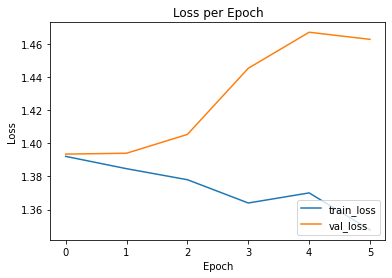

In [ ]:
print_loss_graph(optical_flow_model)

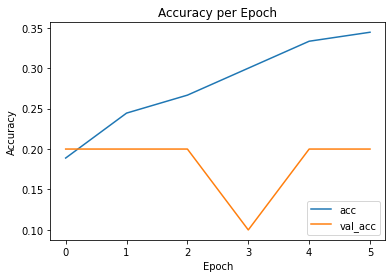

In [ ]:
print_accuracy_graph(optical_flow_model)

In [ ]:
#Create Test set 

mapping = {
    'handShake': '0',
    'highFive': '1',
    'hug': '2',
    'kiss': '3',
}
y_test = [mapping[word] for word in set_1_label]
y_test = [int(word) for word in y_test]
y_test = np.array(y_test)

from sklearn.model_selection import train_test_split

x_test = optical_flow_test_set

In [ ]:
best_model_optical_flow = load_model('/content/drive/MyDrive/best_opticalflow_model.hdf5')

In [ ]:
best_model_optical_flow.evaluate(x_test, y_test) #Test loss and accuracy

4/4 [==============================] - 13s 3s/step - loss: 1.3879 - accuracy: 0.2400


[1.387911319732666, 0.23999999463558197]

Two Stream Model 

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
# Make a combined train generator from the previous generators...

import pathlib
train_data_dir = pathlib.Path('TV-HI/train/')
test_data_dir = pathlib.Path('TV-HI/test/')

fin_datagen = ImageDataGenerator(validation_split=0,
                                  rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

train_img_it = fin_datagen.flow_from_directory(train_data_dir, subset="training", class_mode='sparse',
  target_size=(img_width,img_height), batch_size=BATCH_SIZE, color_mode="rgb")

train_imgs = []

import cv2

for i in range(100):
  train_clip = VideoFileClip(f'TV-HI/tv_human_interactions_videos/{set_2[i]}')
  middle_frame_t = train_clip.duration / 2
  frame = train_clip.get_frame(middle_frame_t)

  frame = cv2.resize(frame, (img_width, img_height))
  train_imgs.append(frame)

Found 100 images belonging to 4 classes.


In [ ]:
#combined = zip(train_opt_it, train_img_it)
mapping = {
    'handShake': '0',
    'highFive': '1',
    'hug': '2',
    'kiss': '3',
}
y_train = [mapping[word] for word in set_2_label]
y_train = [int(word) for word in y_train]
y_train = np.array(y_train)

from sklearn.model_selection import train_test_split

opt_x_train, opt_x_validation, opt_y_train, opt_y_validation = train_test_split(optica_flow_save,y_train,stratify=y_train,test_size=0.1, random_state=123)
img_x_train, img_x_validation, img_y_train, img_y_validation = train_test_split(train_imgs,y_train,stratify=y_train,test_size=0.1, random_state=123)

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras 
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout, Dense, Activation
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping
import os
import pathlib
import numpy as np
import cv2

from keras.models import load_model
from google.colab.patches import cv2_imshow

inputA = tf.keras.Input(shape=(16, 128, 128, 3), name='input_2') #Optical Flow
inputB = tf.keras.Input(shape=(128, 128, 3), name='input_1') #Images

modelA = load_model('/content/best_opticalflow_model.hdf5')
for i in range(4):
  modelA._layers.pop()
streamA = modelA(inputA, training=False)
modelB = load_model('/content/best_stanford_model.hdf5')
for i in range(4):
  modelB._layers.pop()
streamB = modelB(inputB, training=False)
fusion = tf.keras.layers.Concatenate(axis=1)([modelA._layers[-1].output, modelB._layers[-1].output])
x = Dense(128, activation='relu')(fusion)
out = Dense(4, activation='softmax')(x)
twostream_model = tf.keras.Model(inputs=[modelA.input, modelB.input], outputs=out)
twostream_model.summary()
tf.keras.utils.plot_model(twostream_model, to_file='model.png')
twostream_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

#x = Dense(1, activation='sigmoid', name='x_out')(z)
#y = Dense(10, activation='softmax', name='y_out')(z)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 16, 128, 128 0                                            
__________________________________________________________________________________________________
conv3d_4 (Conv3D)               (None, 16, 128, 128, 656         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling3d_4 (MaxPooling3D)  (None, 8, 64, 64, 8) 0           conv3d_4[0][0]                   
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
____________________________________________________________________________________________

In [ ]:
filepath = '/content/drive/MyDrive/best_twostream_model.hdf5'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0), 
            tf.keras.callbacks.ModelCheckpoint(filepath=filepath, 
            monitor='val_loss', verbose=0, save_best_only=True,mode='min')]
 
twostream_history = twostream_model.fit(
  {'input_1': np.array(img_x_train), 'input_2': np.array(opt_x_train)},
  np.array(opt_y_train),
  epochs=NUM_EPOCHS,
  validation_data = ({'input_1': np.array(img_x_validation), 'input_2': np.array(opt_x_validation)}, np.array(opt_y_validation)),
  callbacks = [callbacks]
)

Epoch 1/10
3/3 [==============================] - 60s 18s/step - loss: 1.5815 - accuracy: 0.2322 - val_loss: 1.8329 - val_accuracy: 0.3000
Epoch 2/10
3/3 [==============================] - 56s 18s/step - loss: 1.0927 - accuracy: 0.4597 - val_loss: 1.5256 - val_accuracy: 0.3000
Epoch 3/10
3/3 [==============================] - 56s 18s/step - loss: 0.7801 - accuracy: 0.9126 - val_loss: 1.3879 - val_accuracy: 0.4000
Epoch 4/10
3/3 [==============================] - 56s 18s/step - loss: 0.4862 - accuracy: 0.9772 - val_loss: 1.7287 - val_accuracy: 0.4000
Epoch 5/10
3/3 [==============================] - 56s 18s/step - loss: 0.2806 - accuracy: 0.9827 - val_loss: 1.9668 - val_accuracy: 0.4000
Epoch 6/10
3/3 [==============================] - 56s 18s/step - loss: 0.1196 - accuracy: 0.9944 - val_loss: 2.1293 - val_accuracy: 0.5000
Epoch 7/10
3/3 [==============================] - 56s 18s/step - loss: 0.0508 - accuracy: 1.0000 - val_loss: 3.5143 - val_accuracy: 0.4000
Epoch 8/10
3/3 [===========

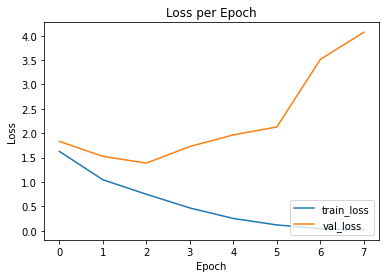

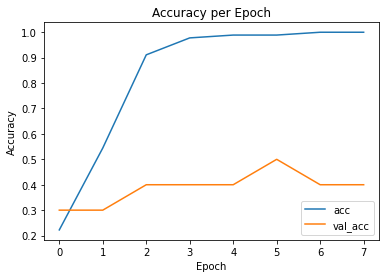

In [ ]:
print_loss_graph(twostream_history)
print_accuracy_graph(twostream_history)

In [ ]:
# test it
test_imgs = []
for i in range(100):
  train_clip = VideoFileClip(f'TV-HI/tv_human_interactions_videos/{set_1[i]}')
  middle_frame_t = train_clip.duration / 2
  frame = train_clip.get_frame(middle_frame_t)

  frame = cv2.resize(frame, (img_width, img_height))
  test_imgs.append(frame)


In [ ]:
best_model_optical_flow = load_model('/content/drive/MyDrive/best_twostream_model.hdf5')
best_model_optical_flow.save('best_model_twostream_weights.h', save_format='h5')

score = best_model_optical_flow.evaluate({'input_1': np.array(test_imgs), 'input_2': np.array(x_test)}, y_test)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

4/4 [==============================] - 15s 3s/step - loss: 1.4382 - accuracy: 0.2900
Test loss: 1.438166618347168 / Test accuracy: 0.28999999165534973


NameError: ignored